In [3]:
import pandas as pd
import datetime as dt
import backtrader as bt
import quantstats as qs
import matplotlib as plt
import numpy as np
import os

os.getcwd()

# 数据加载-------------------------------------
df = pd.read_csv("test_set.csv")  # 绝对路径
df.index = pd.to_datetime(df.date)
df['openinterest'] = 0

# #以下是自己随机添加signal的之后的文件，hmm算法给出的带signal的文件直接用上面的df=pd.read_csv导入，把下面到构建策略之前mute掉即可

# #随机生成一个-1，0，1的predictions序列---------
# sig=[]
# for i in range(len(df)):
#     x=np.random.randn()
#     if x > 0.2:
#         sig.append(1)
#     elif x<-0.2:
#         sig.append(-1)
#     else:
#         sig.append(0)
# df['signal']=sig


# 构建策略-------------------------------------
class TestSignalStrategy(bt.Strategy):
    params = ()

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s,%s' % (dt.isoformat(), txt))

    def __init__(self):
        self.bar_num = 0
        self.signal_df = df
        self.signal_df['date'] = pd.to_datetime(self.signal_df['date'])
        self.first_trade = True

    def prenext(self):
        self.next()

    def next(self):
        self.bar_num += 1
        current_date = self.datas[0].datetime.date(0).strftime("%Y-%m-%d")
        try:
            next_date = self.datas[0].datetime.date(1)
        except:
            next_date = None
        if next_date != None:
            next_signal_df = self.signal_df[self.signal_df['date'] == pd.to_datetime(
                next_date)]
            if len(next_signal_df) == 0:
                self.log("下个交易日的信号不存在")
            else:
                signal = int(next_signal_df['signal'])

                # 第一次交易没有底仓，只允许做多
                # 交易信号的执行方式：
                # 先不考虑卖空
                # signal为1，以当天开盘价全仓买入
                # signal为-1时，以当天开盘价卖出所有持仓
                if self.first_trade:
                    if signal == -1:
                        pass
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)
                        self.first_trade = False
                else:
                    # 现有持仓
                    now_hold_size = self.getposition(self.datas[0]).size
                    if signal == 1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        self.buy(self.datas[0],
                                 size=target_size, price=open_price)

                    if signal == -1:
                        total_value = self.broker.get_value()
                        open_price = self.datas[0].open[0]
                        target_size = total_value//open_price
                        # 卖出开仓，手数不能超过底仓
                        if target_size > now_hold_size:
                            target_size = now_hold_size

                        self.sell(
                            self.datas[0], size=target_size, price=open_price)

    # 订单情况
    def notify_order(self, order):

        # 订单处于未决，继续
        if order.status in [order.Submitted, order.Accepted]:
            return

        # 订单已决
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('买单执行,%.2f' % order.executed.price)

            elif order.issell():
                self.log('卖单执行,%2f' % order.executed.price)

        elif order.status in [order.Canceled, order.Rejected, order.Expired]:
            self.log('订单 Canceled/Rejected/Expired')

    # 交易情况
    def notify_trade(self, trade):
        if trade.isclosed:
            print('毛收益 %0.2f, 扣佣后收益 % 0.2f , 佣金 %.2f'
                  % (trade.pnl, trade.pnlcomm, trade.commission))


cerebro = bt.Cerebro()

stock_df = df[['open', 'high', 'low', 'close', 'volume', 'openinterest']]
data = bt.feeds.PandasData(dataname=stock_df, fromdate=dt.datetime(
    2010, 1, 4), todate=dt.datetime(2021, 12, 31), timeframe=bt.TimeFrame.Days)
cerebro.adddata(data)

# 初始资金设置为10万
cerebro.broker.setcash(100000.0)
# 手续费万分之二
cerebro.broker.setcommission(commission=0.0002)
# 滑点设置 0.5%
cerebro.broker = bt.brokers.BackBroker(slip_perc=0.005)

cerebro.addstrategy(TestSignalStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')

# 运行回测
print('start portfolio value:', format(cerebro.broker.getvalue()))
results = cerebro.run()
print('end portfolio value:', format(cerebro.broker.getvalue()))


# 绩效评价----------------------------
# 获取策略实例
start = results[0]
portfolio_stats = start.analyzers.getbyname('PyFolio')
# 以下returns为以日期为索引的资产日收益率序列
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)

start portfolio value: 10000.0
2013-07-24,买单执行,2253.38
2013-07-26,卖单执行,2226.430000
毛收益 -107.80, 扣佣后收益 -107.80 , 佣金 0.00
2013-08-06,买单执行,2270.67
2013-08-27,卖单执行,2332.800000
毛收益 248.52, 扣佣后收益  248.52 , 佣金 0.00
2013-09-04,买单执行,2352.54
2013-09-26,卖单执行,2422.630000
毛收益 280.36, 扣佣后收益  280.36 , 佣金 0.00
2013-10-18,买单执行,2415.12
2013-10-24,卖单执行,2412.240000
毛收益 -11.52, 扣佣后收益 -11.52 , 佣金 0.00
2013-11-19,买单执行,2427.93
2013-12-03,卖单执行,2410.690000
毛收益 -68.96, 扣佣后收益 -68.96 , 佣金 0.00
2013-12-04,买单执行,2439.82
2013-12-13,卖单执行,2388.660000
毛收益 -204.64, 扣佣后收益 -204.64 , 佣金 0.00
2014-01-28,买单执行,2220.78
2014-02-25,卖单执行,2216.510000
毛收益 -17.08, 扣佣后收益 -17.08 , 佣金 0.00
2014-03-25,买单执行,2170.78
2014-04-23,卖单执行,2191.230000
毛收益 81.80, 扣佣后收益  81.80 , 佣金 0.00
2014-05-15,买单执行,2169.28
2014-05-19,卖单执行,2139.360000
毛收益 -119.68, 扣佣后收益 -119.68 , 佣金 0.00
2014-06-04,买单执行,2149.41
2014-06-10,卖单执行,2138.670000
毛收益 -42.96, 扣佣后收益 -42.96 , 佣金 0.00
2014-06-17,买单执行,2185.68
2014-06-20,卖单执行,2124.960000
毛收益 -242.88, 扣佣后收益 -242.88 , 佣金 0.00
201

                    Strategy
------------------  ----------
Start Period        2013-07-22
End Period          2021-12-30
Risk-Free Rate      0.0%
Time in Market      55.0%

Cumulative Return   77.86%
CAGR﹪              7.05%

Sharpe              0.62
Sortino             0.89
Sortino/√2          0.63
Omega               1.17

Max Drawdown        -22.5%
Longest DD Days     885

Gain/Pain Ratio     0.17
Gain/Pain (1M)      0.58

Payoff Ratio        1.13
Profit Factor       1.17
Common Sense Ratio  1.53
CPC Index           0.67
Tail Ratio          1.31
Outlier Win Ratio   8.55
Outlier Loss Ratio  3.37

MTD                 -1.27%
3M                  -3.88%
6M                  -9.65%
YTD                 -13.41%
1Y                  -11.22%
3Y (ann.)           8.17%
5Y (ann.)           3.04%
10Y (ann.)          7.05%
All-time (ann.)     7.05%

Avg. Drawdown       -4.52%
Avg. Drawdown Days  96
Recovery Factor     3.46
Ulcer Index         0.1
Serenity Index      0.33


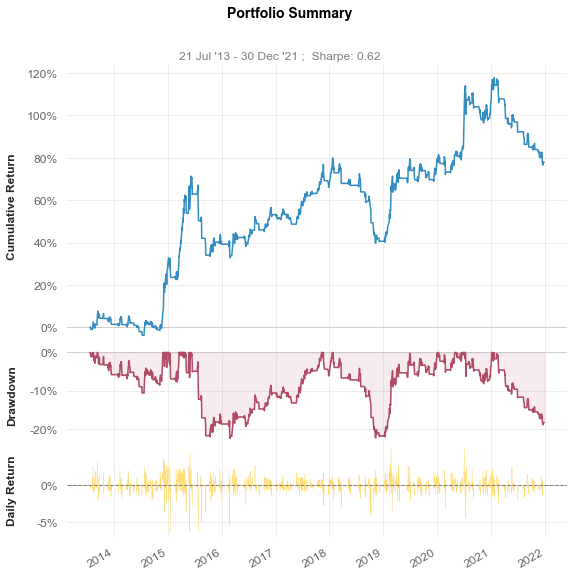

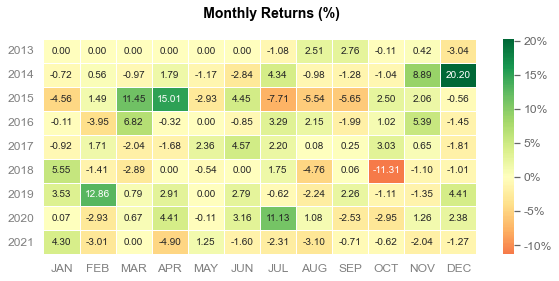

In [4]:
# 画图仍只能在notebook中输出(将basic改成full的话可以得到更多的输出结果，但其中一个return distribution的表会报错)
qs.reports.basic(returns, benchmark=None, rf=0.0,
                 grayscale=False, display=True, compounded=True)

                           Strategy
-------------------------  ----------
Start Period               2013-07-22
End Period                 2021-12-30
Risk-Free Rate             0.0%
Time in Market             55.0%

Cumulative Return          77.86%
CAGR﹪                     7.05%

Sharpe                     0.62
Smart Sharpe               0.57
Sortino                    0.89
Smart Sortino              0.82
Sortino/√2                 0.63
Smart Sortino/√2           0.58
Omega                      1.17

Max Drawdown               -22.5%
Longest DD Days            885
Volatility (ann.)          12.62%
Calmar                     0.31
Skew                       -0.65
Kurtosis                   13.28

Expected Daily %           0.03%
Expected Monthly %         0.57%
Expected Yearly %          6.61%
Kelly Criterion            7.38%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.28%
Expected Shortfall (cVaR)  -1.28%

Gain/Pain Ratio            0.17
Gain/Pain (1M)             0.

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-06-09,2016-02-25,2017-11-10,885,-22.499339,-21.804822
2,2018-01-25,2018-11-12,2020-01-13,718,-22.386359,-21.890208
3,2021-01-26,2021-12-20,2021-12-30,338,-18.958694,-17.934860
4,2013-09-13,2014-07-11,2014-11-28,441,-10.610426,-10.367683
5,2020-07-14,2020-11-13,2021-01-07,177,-8.188389,-7.575666


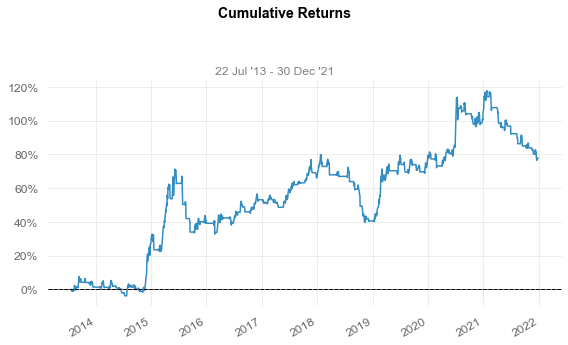

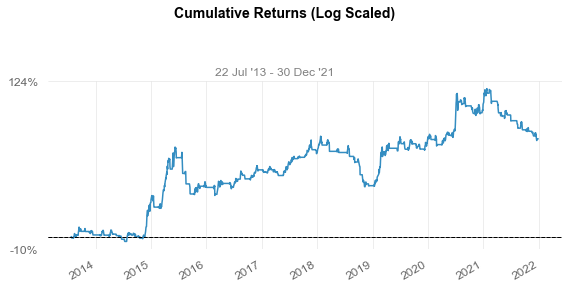

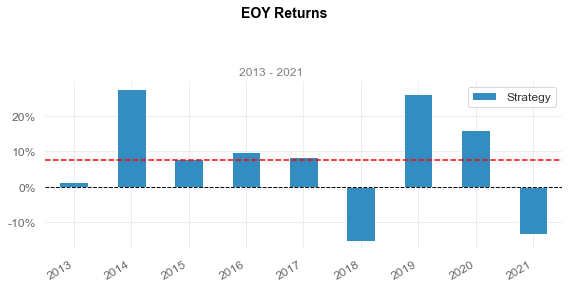

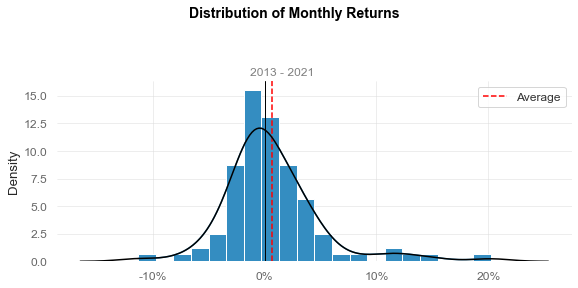

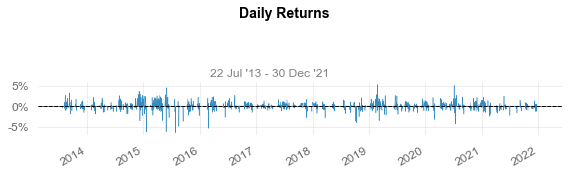

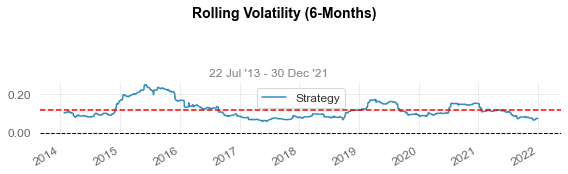

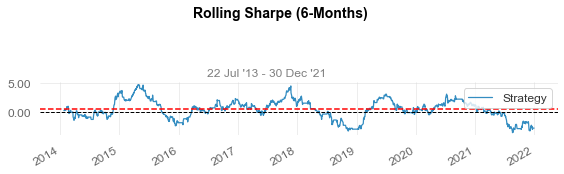

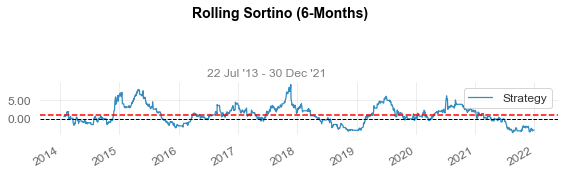

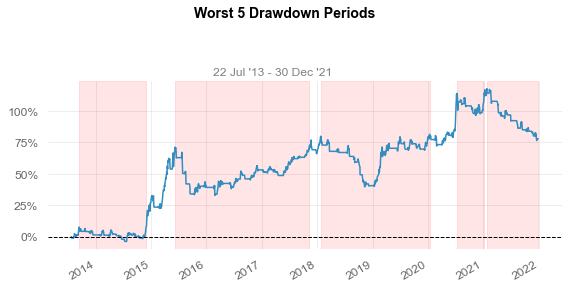

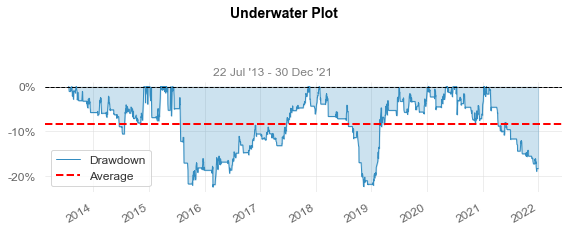

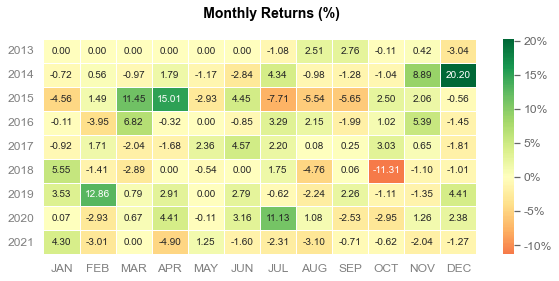

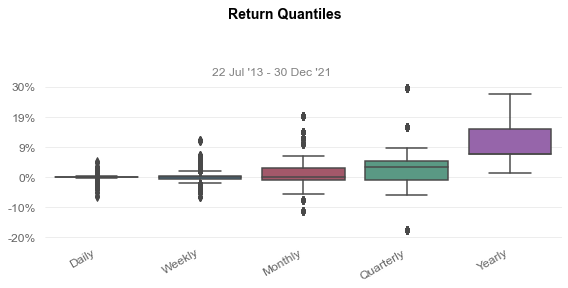

In [5]:
# 画图仍只能在notebook中输出
qs.reports.full(returns, benchmark=None, rf=0.0,
                grayscale=False, display=True, compounded=True)